In [2]:
import matplotlib.pyplot as plt
import librosa as lb
import numpy as np
import scipy.signal as ss
import scipy.optimize as so
from scipy.fft import fft, ifft
import soundfile as sf
from scipy.signal.windows import gaussian
import os

In [ ]:
# Fonction qui sert a connaitre la longueur d'une base de données
def longueur_bdd(list_path_dir,f_ech=44100,disp=True):
    # Initialisation des variables
    temps=np.zeros(len(list_path_dir))
    iterateur=0
    # On parcourt la liste de nom de dossier en input
    for i in list_path_dir:
        # On regarde toutes les entrées dans ce répertoire
        files_mu=os.scandir(i)
        # Si ces entrées ont la bonne forme alors on calcule leur longueur en seconde
        for entry in files_mu:
            if entry.name.endswith('pb.mp3') and entry.is_file() :
                y,sr=lb.load(i+'/'+entry.name,sr=f_ech)
                a=np.shape(y)[0]/sr
                temps[iterateur]=temps[iterateur]+a
        # Affichage
        if disp==True:
            print("La durée des musiques mixé dans le dossier %s est de %dh%dm%ds"%(i,np.int32(temps[iterateur]/3600),(np.int32(temps[iterateur]/60)%60),np.int32(temps[iterateur])%60))
        iterateur+=1
        # Pour libérer les ressources prise par files_mu
        files_mu.close()
    return(temps)

# Fonction à optimiser. Cette fonction calcule l'energie du signal x0-scale_factor*x1. 
# Avec x0 et x1 des veccteurs et scale_factor un scalaire
def calc_energy(scale_factor,x0,x1):
    ener=(x0-scale_factor*x1)
    return(np.sum(np.abs(ener)))

# Fonction qui va réaliser l'optimisation.
def optimisation_signal(signal_full,signal_back_decal):
    #initialisation du scale factor
    scale_fact=1
    # Limites du scale factor
    bnd=[(-10,10)]
    # Calcul de la solution au problème d'optimisation evec x0 et x1 = respectivement a signal_full et signal_back_decal
    res=so.minimize(calc_energy,scale_fact,method='nelder-mead',args=(signal_full,signal_back_decal),bounds=bnd,options={'maxiter': 100, 'disp': False})
    return(res.x)


# Fonction qui Vérifie que le signal audio est bien centré en 0. Sinon le centre
def centrage_zero(signal,err=10e-3):
    mean=np.mean(signal)
    # print(mean)
    if(np.abs(mean)<err):
        return(signal)
    else:
        return(signal-mean)



def calcul_soliste(signal_full,signal_background,decal_signal,fech=44100,temps_ou_nb=True,path_file=None,opti_energie=False,stereo=False):
    #### Fonction qui calcule le nouveau signal a partir du décalage entre 2 audio.
    # signal_full prends en entrée le signal audio full.
    # signal_background prends en entrée le signal audio background.
    # fech est la fréquence d'échantillonage des signaux audio.
    # decal_signal est le décalge à réaliser (en nombre d'élément ou en temps) pour mettre les audio en phase
    # temps_ou_nb est pour indiquer si le décalage est en nombre d'élément ou en temps True si le décalage est en temps, False sinon.
    # Path_file indique ou et sous quelle nom enregistrer les fichiers. Nous enregistrons les fichiers dans le même format que celui initiale.
    # Si path_file=None alors nous enregistrons dans le répertoire courant.
    # Si opti_energie=True alors nous allons réaliser une optimisation pour trouver le scale factor entre les deux audio. A utiliser si les deux audio n'ont pas le même facteur d'échelle.
    # Si stereo=True alors les signaux en sortie seront enregistrés en stereo avec le canal droit et le canal gauche qui sont identique. Sinon les signaux seront enregistré en mono.
    # La fonction ne renvoie rien mais écris sur le disque le signal du soliste seul déduit a partir du décalage indiquer ainsi que le signal mix et le signal background alignés avec le mix.
    # Les fichiers se nomment respectivement soliste, mixture, other. Leur extension sera la même que ceux des fichiers d'entrées.


    # Permet de connaitre le décalage ne nombre d'élement
    if temps_ou_nb == True:
        nb_decal_elem=np.int32(np.round(decal_signal*fech))
    else:
        nb_decal_elem=decal_signal

    # Calcul du signal background decalé a partir du nombre de décalage et du signal background d'origine.
    # Le signal background décalé a désormais la méme taille que signal_full 
    signal_back_decal=np.zeros(np.shape(signal_full))
    if(np.shape(signal_full)[0]+nb_decal_elem>np.shape(signal_background)[0]):
        if nb_decal_elem<0 :
            signal_back_decal[-nb_decal_elem:np.shape(signal_background)[0]-nb_decal_elem]=signal_background[:]
            
        else:
            signal_back_decal[:np.shape(signal_background)[0]-nb_decal_elem]=signal_background[nb_decal_elem:]
            
    else:
        if nb_decal_elem<0 :
            signal_back_decal[-nb_decal_elem:]=signal_background[:nb_decal_elem+np.shape(signal_full)[0]]
           
        else:
            signal_back_decal[:]=signal_background[nb_decal_elem:nb_decal_elem+np.shape(signal_full)[0]]
            
            
    # Réalise l'optimisation pour trouver le scale factor entre signal_full et signal_back_decal
    if opti_energie==True:
        scale_fact=optimisation_signal(signal_full,signal_back_decal)
        print("Le scale factor vaut :", scale_fact[0])
        signal_soliste=signal_full-scale_fact*signal_back_decal
    else:
        signal_soliste=signal_full-signal_back_decal

    # Fais en sorte que les signaux audio que nous allons enregistré soit en stereo en non en mono
    if stereo==True:
            signal_sol_stereo=np.zeros([np.shape(signal_soliste)[0],2])
            signal_sol_stereo[:,0]=signal_soliste
            signal_sol_stereo[:,1]=signal_soliste

            signal_full_stereo=np.zeros([np.shape(signal_soliste)[0],2])
            signal_full_stereo[:,0]=signal_full
            signal_full_stereo[:,1]=signal_full

            signal_back_stereo=np.zeros([np.shape(signal_soliste)[0],2])
            signal_back_stereo[:,0]=signal_back_decal
            signal_back_stereo[:,1]=signal_back_decal
    
    # enregistre les fichiers dans le dossier dir_to_save indiquer.
    # Va enregistrer selon l'arborescence premier fichier dans sous dossier 01 de dossier dir_to_save et ainsi de suite.
    # à changer pour d'autre usage car très adapter a notre base de données. (vérifaction de quelle partie de la base de données et du numéro dans la nom du fichier) 
    if path_file is not None:
        dir_to_save='./bdd_v4/'
        path_fin=path_file.split('/')
        path_fin=path_fin[len(path_fin)-1]
        numero_fichier=path_fin.split('-')[1]
        extension_fichier=path_fin.split('.')[1]
        print(path_file.split('/'))
        if(path_file.split('/')[2]=='jacob_do_bandolim'):
            numero_fichier=str(np.int32(numero_fichier)+12)
            
        path_dir=dir_to_save+numero_fichier+'/'
        path_soliste=path_dir+'soliste'+'.'+extension_fichier
        path_mix=path_dir+'mixture'+'.'+extension_fichier
        path_other=path_dir+'others'+'.'+extension_fichier

        # print(np.shape(signal_soliste))
        # print(np.shape(signal_full))
        # print(np.shape(signal_back_decal))
        
        if stereo==True:
            sf.write(path_soliste, signal_sol_stereo, fech, )
            sf.write(path_mix, signal_full_stereo, fech, )
            sf.write(path_other, signal_back_stereo, fech, )
        else:
            sf.write(path_soliste, signal_soliste, fech, )
            sf.write(path_mix, signal_full, fech, )
            sf.write(path_other, signal_back_decal, fech, )
    #Enregistre dans le répertoire courant en mp3
    else:
        print(np.shape(signal_soliste))
        sf.write('soliste.mp3', signal_soliste, fech, )
        sf.write('mix.mp3', signal_full, fech, )
        sf.write('other.mp3', signal_back_decal, fech, )




def calcul_decalage(path_file_full,path_file_background,fech=44100,plot=False,calcul_signal=True,path_file_fonction=None,opti_energi=False,stereo=False):
    #### Fonction qui calcule le décalage entre 2 audio en utilisant la corrélation
    # path_file_full prends en entrée le chemin vers le fichier audio entier. Cela doit être une chaine de caractère.
    # path_file_background prends en entrée le chemin vers le fichier audio qui n'a que le background. Cela doit être une chaine de caractère.
    # fech est la fréquence d'échantillonage des signaux audio
    # plot est pour afficher la correlation
    # Si calcul_signal=true alors cette fonction appeleras la fonction calcul_soliste
    # path_file_fonction permet d'indiquer le chemin pour la fonction calcul_soliste. (argument path_file de la fonction calcul_soliste)
    # opti_energi  permet d'indiquer si la fonction calcul_soliste doit faire une optimisation pour calculer la scale factor
    # stereo permet d'indiquer si la fonction calcul_soliste doit enregistré en stereo ou en mono.
    # La fonction renvoie en 1er argument le décalage en temps et en deuxième argument le décalage en nombre de décalage a faire pour les aligner.
    
    # Charger les signaux
    y, sr = lb.load(path_file_full,sr=fech)
    y2, sr2 = lb.load(path_file_background,sr=fech)

    # Vérification du centrage
    y=centrage_zero(y)
    y2=centrage_zero(y2)

    # Crop des fichiers pour la corrélation pour réduire le temps de calcul
    milieu_signal=np.int32(np.max(np.shape(y))/(2*sr))
    # print("milieu signal = ",milieu_signal)
    temps_deb_f=(milieu_signal-25)*sr
    temps_fin_f=(milieu_signal+25)*sr
    temps_deb_b=(milieu_signal-10)*sr
    temps_fin_b=(milieu_signal+10)*sr
    signal_tout=np.array(y)
    signal_backgroung=np.array(y2)
    signal_full_tronque=signal_tout[temps_deb_f:temps_fin_f]
    signal_backgroung_tronque=signal_backgroung[temps_deb_b:temps_fin_b]

    # Calcul de la corrélation
    corr_mes=ss.correlate(signal_backgroung_tronque,signal_full_tronque,'valid')

    if plot==True :
        temps=(np.arange(np.max(np.shape(signal_full_tronque)))/sr-25)
        len_cor=np.max(np.shape(corr_mes))
        len_tp=np.max(np.shape(signal_full_tronque))
        plt.figure()
        plt.plot(temps[np.int32((len_tp-len_cor)/2):np.int32((len_tp+len_cor)/2)],corr_mes)
        plt.title("Mesure de la corrélation entre les 2 signaux audio")
        plt.xlabel("temps en seconde")
        plt.ylabel("score de correlation")
        plt.show()
    # Calcul du décalage
    pos_max=np.argwhere(corr_mes==np.max(corr_mes))
    temps=(temps_deb_f+pos_max[0][0])/sr
    decalage=temps-temps_deb_b/sr
    print('le décalage est de',decalage,'s')
    # Calcul soliste
    if calcul_signal ==True :
        calcul_soliste(y,y2,decalage,sr,path_file=path_file_fonction,opti_energie=opti_energi,stereo=stereo)
    return(decalage,pos_max[0][0])

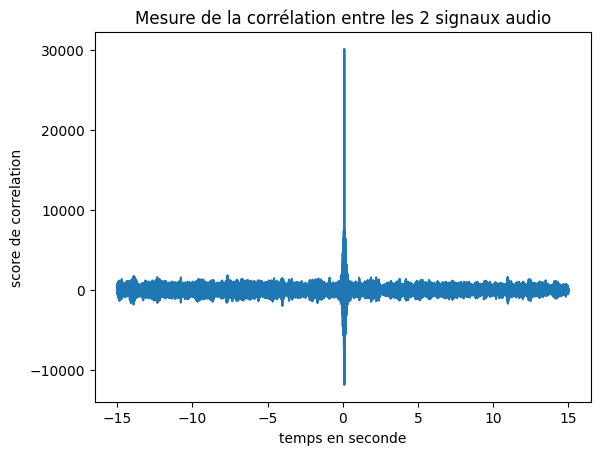

le décalage est de 0.10331065759636715 s
Le scale factor vaut : 0.8505249023437498
['.', 'base_donnees', 'deo_rian', 'DR-02-bruno-no-choro-ft.mp3']
(7112418,)
(7112418,)
(7112418,)


In [ ]:
# changer les paths si vous n'avez pas ces fichiers
path_1='./base_donnees/deo_rian/DR-02-bruno-no-choro-ft.mp3'
path_2='./base_donnees/deo_rian/DR-02-bruno-no-choro-pb.mp3'
dc , nb_decal = calcul_decalage(path_1,path_2,fech=44100,path_file_fonction=path_1,plot=True,opti_energi=True,stereo=False)


In [7]:
x=os.scandir("./base_donnees/deo_rian")
print("musique song in deo rian :")
for f in x:
    if f.name.endswith('pb.mp3') and f.is_file() :
        print(f.name)
x.close()

musique song in deo rian :
DR-01-branquinha-pb.mp3
DR-02-bruno-no-choro-pb.mp3
DR-03-choro-simples-pb.mp3
DR-04-choroes-do-bandolim-de-ouro-pb.mp3
DR-05-com-dor-e-tudo-pb.mp3
DR-06-deo-rian-aos-setenta-pb.mp3
DR-07-lembrancas-de-um-violao-pb.mp3
DR-08-na-casa-do-manoel-rigaud-pb.mp3
DR-09-o-pandeiro-do-darly-pb.mp3
DR-10-o-sarau-do-luiz-santana-pb.mp3
DR-11-pensando-na-vida-pb.mp3
DR-12-tres-amigos-pb.mp3


In [ ]:
liste_bdd=["./base_donnees/deo_rian","./base_donnees/jacob_do_bandolim"]
lenght_bdd=longueur_bdd(liste_bdd,f_ech=44100)

La durée des musiques mixé dans le dossier ./base_donnees/deo_rian est de 0h38m58s
La durée des musiques mixé dans le dossier ./base_donnees/jacob_do_bandolim est de 0h36m18s
[2338.85707483 2178.71907029]


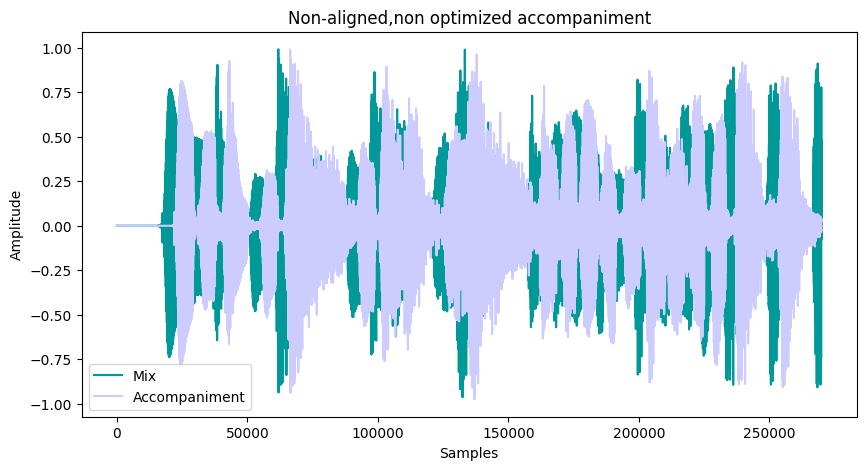

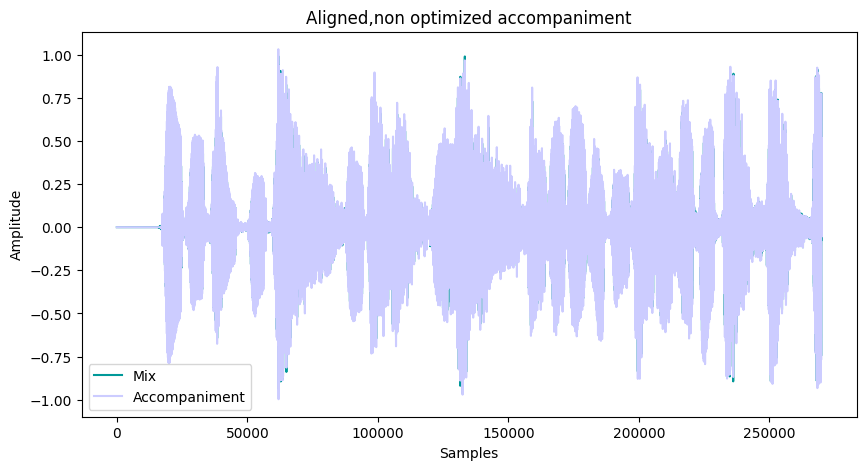

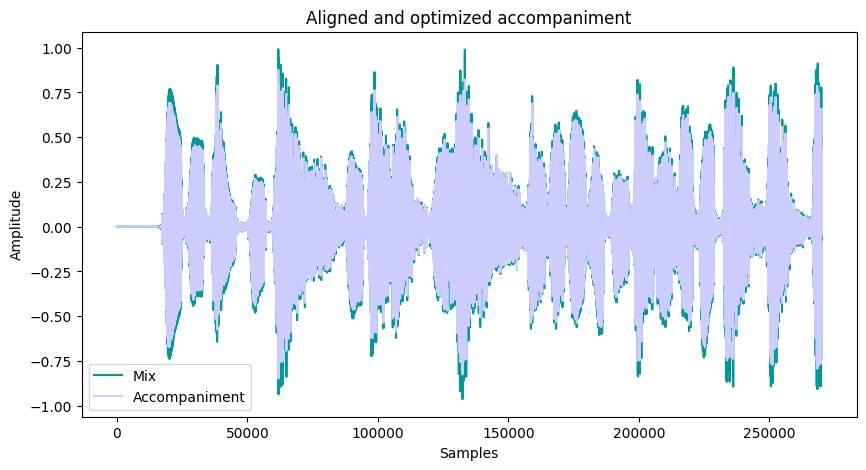

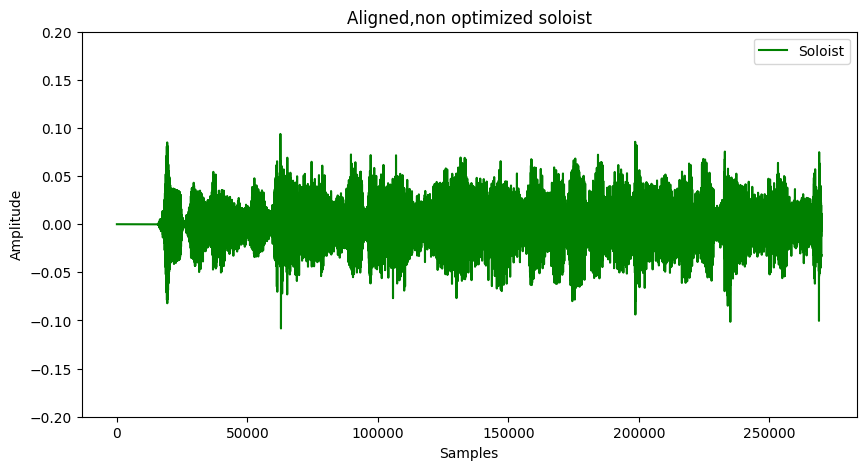

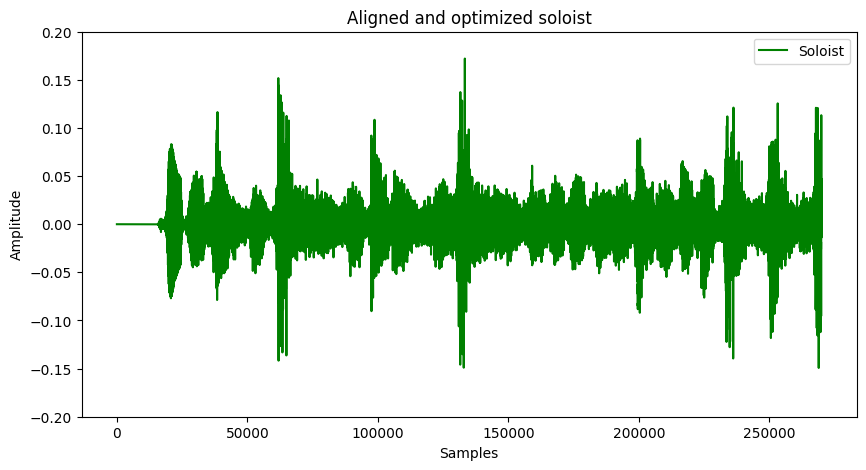

In [41]:
path_test1='./bdd_v4/02/soliste.mp3'
path_test2='./bdd_v4/02/others.mp3'
path_test3='./bdd_v4/02/mixture.mp3'
path_test4='./base_donnees/deo_rian/DR-02-bruno-no-choro-ft.mp3'
path_test7='./base_donnees/deo_rian/DR-02-bruno-no-choro-pb.mp3'
path_test5='./bdd/other_DR-02-bruno-no-choro-ft.mp3'
path_test8='./bdd/soliste_DR-02-bruno-no-choro-ft.mp3'
fech=44100
alpha=0.8505249
y, sr = lb.load(path_test1,sr=fech)
y2, sr2 = lb.load(path_test2,sr=fech)
y3, sr3 = lb.load(path_test3,sr=fech)
y4, sr4 = lb.load(path_test4,sr=fech)
y5, sr5 = lb.load(path_test5,sr=fech)
y7, sr7 = lb.load(path_test7,sr=fech)
y8, sr8 = lb.load(path_test8,sr=fech)
y6=alpha*y2
plt.figure(figsize=(10,5))
plt.plot(y4[:270000],color='#009999')
plt.plot(y7[:270000],color='#CCCCFF')
plt.legend(['Mix','Accompaniment'])
plt.title('Non-aligned,non optimized accompaniment')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(y4[:270000],color='#009999')
plt.plot(y2[:270000],color='#CCCCFF')
plt.legend(['Mix','Accompaniment'])
plt.title('Aligned,non optimized accompaniment')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(y4[:270000],color='#009999')
plt.plot(y6[:270000],color='#CCCCFF')
plt.legend(['Mix','Accompaniment'])
plt.title('Aligned and optimized accompaniment')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y8[:270000],color='g')
plt.legend(['Soloist'])
plt.title('Aligned,non optimized soloist')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.ylim(-0.2,0.2)
plt.show()


plt.figure(figsize=(10,5),)
plt.plot(y[:270000],color='g',)
plt.legend(['Soloist'])
plt.title('Aligned and optimized soloist')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.ylim(-0.2,0.2)
plt.show()

[[108]]


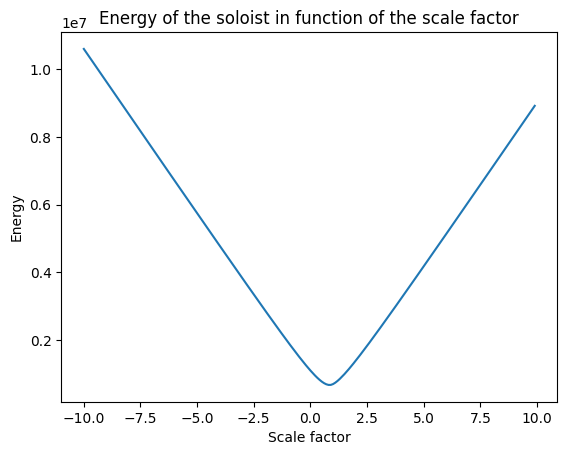

In [ ]:
path_test4='./base_donnees/deo_rian/DR-02-bruno-no-choro-ft.mp3'
path_test5='./bdd/other_DR-02-bruno-no-choro-ft.mp3'
y4, sr4 = lb.load(path_test4,sr=fech)
y5, sr5 = lb.load(path_test5,sr=fech)
liste_energie=[]
alpha=np.arange(200)/100
for i in alpha:
    liste_energie.append(calc_energy(i,y4,y5))

plt.figure()
plt.plot(alpha,liste_energie)
print(np.argwhere(liste_energie==np.min(liste_energie)))
plt.title('Energy of the soloist in function of the scale factor')
plt.ylabel('Energy')
plt.xlabel('Scale factor')
plt.show()